In [1]:
#default_exp models

In [2]:
#hide
from nbdev import *
%load_ext autoreload
%autoreload 2

# Models

> Uniserie models implementations.

In [3]:
#hide
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from nbdev.showdoc import add_docs, show_doc

In [4]:
#export
from itertools import count
from numbers import Number
from typing import Collection, List, Optional, Sequence, Tuple

import numpy as np
import pandas as pd
from numba import njit
from scipy.optimize import minimize

from statsforecast.arima import auto_arima_f, forecast_arima, fitted_arima
from statsforecast.ets import ets_f, forecast_ets

In [5]:
#hide
from statsforecast.utils import AirPassengers as ap

In [6]:
#exporti
class _TS:
    
    def new(self):
        b = type(self).__new__(type(self))
        b.__dict__.update(self.__dict__)
        return b

## ARIMA methods 

In [7]:
#export
class AutoARIMA(_TS):
    
    def __init__(
            self, 
            season_length: int = 1, # Number of observations per cycle
            approximation: bool = False, #
        ):
        self.season_length = season_length
        self.approximation = approximation
        
    def __repr__(self):
        return f'AutoARIMA()'
    
    def fit(
            self, 
            y: np.ndarray, # time series
            X: Optional[np.ndarray] = None, # exogenous regressors
        ):
        with np.errstate(invalid='ignore'):
            self.model_ = auto_arima_f(
                y, 
                xreg=X,
                period=self.season_length, 
                approximation=self.approximation,
                allowmean=False, allowdrift=False #not implemented yet
            )
        return self
    
    def predict(
            self, 
            h: int, # forecasting horizon 
            X: np.ndarray = None, # exogenous regressors
            level: Optional[Tuple[int]] = None, # level 
        ):
        fcst = forecast_arima(self.model_, h=h, xreg=X, level=level)
        if level is None:
            return fcst['mean']
        out = [
            fcst['mean'],
            *[fcst['lower'][f'{l}%'] for l in level],
            *[fcst['upper'][f'{l}%'] for l in level],
        ]
        return np.vstack(out).T
    
    def predict_in_sample(self):
        return fitted_arima(self.model_)
    
    def forecast(
            self, 
            y: np.ndarray, # time series
            h: int, # forecasting horizon 
            X: np.ndarray = None, # exogenous regressors
            X_future: np.ndarray = None, # future regressors
            level: Optional[Tuple[int]] = None, # level
            fitted: bool = False, # return fitted values?
        ):
        with np.errstate(invalid='ignore'):
            mod = auto_arima_f(
                y,
                xreg=X,
                period=self.season_length,
                approximation=self.approximation,
                allowmean=False, allowdrift=False #not implemented yet
            )
        fcst = forecast_arima(mod, h, xreg=X_future, level=level)
        mean = fcst['mean']
        if fitted:
            return {'mean': mean, 'fitted': fitted_arima(mod)}
        if level is None:
            return {'mean': mean}
        return {
            'mean': mean,
            **{f'lo-{l}': fcst['lower'][f'{l}%'] for l in reversed(level)},
            **{f'hi-{l}': fcst['upper'][f'{l}%'] for l in level},
        }

In [8]:
#hide
from statsforecast.utils import AirPassengers as ap

def test_class(cls_, x, h, skip_insample=False):
    cls_ = cls_.fit(x)
    fcst_cls = cls_.predict(h=h)
    test_eq(len(fcst_cls), h)
    test_eq(len(arima.predict_in_sample()), len(x))
    # test fit + predict equals forecast
    test_eq(
        cls_.forecast(y=x, h=h)['mean'],
        fcst_cls
    )
    if not skip_insample:
        assert isinstance(cls_.predict_in_sample(), np.ndarray)
        np.testing.assert_array_equal(
            cls_.forecast(y=x, h=h, fitted=True)['fitted'],
            cls_.predict_in_sample(), 
        )

In [9]:
#hide
arima = AutoARIMA(season_length=12)
test_class(arima, x=ap, h=12)

In [10]:
#hide
add_docs(
    AutoARIMA, 'Classical AutoARIMA model',
    forecast='Fit and predict without storing objects',
    fit='Fits the model and saves it',
    predict='Predict using the fitted model',
    predict_in_sample='Return fitted values',
)

In [11]:
show_doc(AutoARIMA, default_cls_level=3)

<h3 id="AutoARIMA" class="doc_header"><code>class</code> <code>AutoARIMA</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>AutoARIMA</code>(**`season_length`**:`int`=*`1`*, **`approximation`**:`bool`=*`False`*) :: `_TS`

Classical AutoARIMA model

||Type|Default|Details|
|---|---|---|---|
|**`season_length`**|`int`|`1`|Number of observations per cycle|
|**`approximation`**|`bool`|`False`||


The `AutoARIMA` class instantiates the model.

In [12]:
arima = AutoARIMA(season_length=12)

In [13]:
show_doc(AutoARIMA.forecast)

<h4 id="AutoARIMA.forecast" class="doc_header"><code>AutoARIMA.forecast</code><a href="__main__.py#L49" class="source_link" style="float:right">[source]</a></h4>

> <code>AutoARIMA.forecast</code>(**`y`**:`ndarray`, **`h`**:`int`, **`X`**:`ndarray`=*`None`*, **`X_future`**:`ndarray`=*`None`*, **`level`**:`Optional`\[`Tuple`\[`int`\]\]=*`None`*, **`fitted`**:`bool`=*`False`*)

Fit and predict without storing objects

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|
|**`X_future`**|`ndarray`|`None`|future regressors|
|**`level`**|`typing.Optional[typing.Tuple[int]]`|`None`|level|
|**`fitted`**|`bool`|`False`|return fitted values?|


Once `AutoARIMA` is instantiated, you can make forecasts directly using the `AutoARIMA.forecast` method. The purpose of this method is to avoid computational burden due to object storage. This method can be thought of as a `fit_predict` without storing information. This method assumes you know the forecast horizon in advance. Observe that the method a returns a `dict` object instead of a numpy array.

In [14]:
from statsforecast.utils import AirPassengers as ap
arima.forecast(y=ap, h=12)

{'mean': array([444.30005077, 418.2100203 , 446.23703401, 488.22892853,
        499.23136059, 562.23063085, 649.23084981, 633.23078411,
        535.23080382, 488.23079791, 417.23079968, 459.23079915])}

In [15]:
show_doc(AutoARIMA.fit)

<h4 id="AutoARIMA.fit" class="doc_header"><code>AutoARIMA.fit</code><a href="__main__.py#L15" class="source_link" style="float:right">[source]</a></h4>

> <code>AutoARIMA.fit</code>(**`y`**:`ndarray`, **`X`**:`Optional`\[`ndarray`\]=*`None`*)

Fits the model and saves it

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`X`**|`typing.Optional[numpy.ndarray]`|`None`|exogenous regressors|


If you want to store the fitted model for future analysis, you can use the `AutoARIMA.fit` method. 

In [16]:
arima = arima.fit(y=ap)

In [17]:
show_doc(AutoARIMA.predict)

<h4 id="AutoARIMA.predict" class="doc_header"><code>AutoARIMA.predict</code><a href="__main__.py#L30" class="source_link" style="float:right">[source]</a></h4>

> <code>AutoARIMA.predict</code>(**`h`**:`int`, **`X`**:`ndarray`=*`None`*, **`level`**:`Optional`\[`Tuple`\[`int`\]\]=*`None`*)

Predict using the fitted model

||Type|Default|Details|
|---|---|---|---|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|
|**`level`**|`typing.Optional[typing.Tuple[int]]`|`None`|level|


You can compute forecasts for the fitted model using `AutoARIMA.predict`.

In [18]:
arima.predict(h=12)

array([444.30005077, 418.2100203 , 446.23703401, 488.22892853,
       499.23136059, 562.23063085, 649.23084981, 633.23078411,
       535.23080382, 488.23079791, 417.23079968, 459.23079915])

In [19]:
show_doc(AutoARIMA.predict_in_sample)

<h4 id="AutoARIMA.predict_in_sample" class="doc_header"><code>AutoARIMA.predict_in_sample</code><a href="__main__.py#L46" class="source_link" style="float:right">[source]</a></h4>

> <code>AutoARIMA.predict_in_sample</code>()

Return fitted values

To obtain the fitted values, you can use `AutoARIMA.predict_in_sample`.

In [20]:
arima.predict_in_sample()

array([111.93533678, 117.96643416, 131.96619385, 128.97744815,
       120.98924613, 134.97817413, 147.96920714, 147.97307246,
       135.98742515, 119.00485619, 104.01874673, 118.0777757 ,
       115.42699043, 121.23080941, 138.49974616, 137.69994923,
       127.90015231, 139.60010154, 158.99949231, 167.59959385,
       158.        , 141.        , 120.40040615, 129.20020308,
       133.39939078, 153.59959385, 166.80030461, 168.09934001,
       155.70045692, 190.29903539, 204.40091384, 199.        ,
       187.        , 159.90015231, 142.09984769, 171.09984769,
       172.80030461, 176.        , 206.79979693, 182.50076153,
       189.09984769, 191.10035538, 230.29852771, 232.70045692,
       223.39939078, 192.40091384, 173.79979693, 192.90015231,
       198.39989846, 205.90015231, 211.70045692, 215.89862924,
       233.69944154, 266.40040615, 261.30106614, 273.29954308,
       240.20020307, 219.60010154, 194.40040615, 205.60060922,
       203.30005077, 203.69994923, 232.8008123 , 231.89

### Model Description

**Auto ARIMA**: Automatically selects the best ARIMA (AutoRegressive Integrated Moving Average) model using an information criterion. Default is the corrected Akaike Information Criterion (AICc). Information criterions are tests used to check how well a model fits the data it is trying to describe. 

The ARIMA models are based in the autocorrelations in the data and the autocorrelations of the forecast errors. Every model has three components: AR, I, and MA. 

An AR(p) model captures the autocorrelations in the data at lags $1,2,\dots p$. 

$$y_t = \beta_0+\beta_1y_{t-1}+\beta_2y_{t-2}+\dots+\beta_py{t_p}+\epsilon_t$$

If the autocorrelations of the forecast errors are added up to lag $q$, an ARMA(p,q) model is obtained. 

$$y_t = \beta_0+\beta_1y_{t-1}+\beta_2y_{t-2}+\dots+\beta_py{t_p} + \epsilon_t+\theta_1 \epsilon_{t-1}+\theta_2\epsilon_{t-2}+\dots\theta_q\epsilon_{t-q}$$

The last component of an ARIMA model is the integrated (I) part, which is a differencing operation. The order of differencing, denoted by $d$, indicates how many rounds of lag-1 differencing are performed. 

ARIMA models requiere the user to select $p$, $q$, and $d$. The values for $\beta_i, i=1,2,\dots,p$ and $\theta_j, j=1,2,\dots,q$ are then estimated. Auto ARIMA automatically makes this selection, searching over a range of possible values for $p$, $q$, and $d$, and then choosing the best model using an information criterion. 

## Exponential smoothing methods 

In [21]:
#export
class ETS(_TS):
    
    def __init__(self, season_length: int = 1, model: str = 'ZZZ'):
        self.season_length = season_length
        self.model = model
    
    def __repr__(self):
        return f'ETS(sl={self.season_length},model={self.model})'
    
    def fit(
            self,
            y: np.ndarray, # time series 
            X: np.ndarray = None # exogenous regressors
        ):
        self.model_ = ets_f(y, m=self.season_length, model=self.model)
        return self
    
    def predict(
            self,
            h: int, # forecasting horizon 
            X: np.ndarray = None # exogenous regressors
        ):
        return forecast_ets(self.model_, h=h)['mean']
    
    def predict_in_sample(self):
        return self.model_['fitted']
    
    def forecast(
            self, 
            y: np.ndarray, # time series
            h: int, # forecasting horizon 
            X: np.ndarray = None, # exogenous regressors
            X_future: np.ndarray = None, # future regressors
            fitted: bool = False, # return fitted values?
        ):
        mod = ets_f(y, m=self.season_length, model=self.model)
        fcst = forecast_ets(mod, h)
        keys = ['mean']
        if fitted:
            keys.append('fitted')
        return {key: fcst[key] for key in keys}

In [22]:
#hide
ets = ETS(season_length=12)
test_class(ets, x=ap, h=12)

In [23]:
#hide
add_docs(
    ETS, 'Error, Trend, and Seasonality',
    forecast='Fit and predict without storing objects',
    fit='Fits the model and saves it',
    predict='Predict using the fitted model',
    predict_in_sample='Return fitted values',
)

In [24]:
show_doc(ETS, default_cls_level=3)

<h3 id="ETS" class="doc_header"><code>class</code> <code>ETS</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>ETS</code>(**`season_length`**:`int`=*`1`*, **`model`**:`str`=*`'ZZZ'`*) :: `_TS`

Error, Trend, and Seasonality

In [25]:
show_doc(ETS.forecast)

<h4 id="ETS.forecast" class="doc_header"><code>ETS.forecast</code><a href="__main__.py#L29" class="source_link" style="float:right">[source]</a></h4>

> <code>ETS.forecast</code>(**`y`**:`ndarray`, **`h`**:`int`, **`X`**:`ndarray`=*`None`*, **`X_future`**:`ndarray`=*`None`*, **`fitted`**:`bool`=*`False`*)

Fit and predict without storing objects

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|
|**`X_future`**|`ndarray`|`None`|future regressors|
|**`fitted`**|`bool`|`False`|return fitted values?|


In [26]:
show_doc(ETS.fit)

<h4 id="ETS.fit" class="doc_header"><code>ETS.fit</code><a href="__main__.py#L11" class="source_link" style="float:right">[source]</a></h4>

> <code>ETS.fit</code>(**`y`**:`ndarray`, **`X`**:`ndarray`=*`None`*)

Fits the model and saves it

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [27]:
show_doc(ETS.predict)

<h4 id="ETS.predict" class="doc_header"><code>ETS.predict</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>ETS.predict</code>(**`h`**:`int`, **`X`**:`ndarray`=*`None`*)

Predict using the fitted model

||Type|Default|Details|
|---|---|---|---|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [28]:
show_doc(ETS.predict_in_sample)

<h4 id="ETS.predict_in_sample" class="doc_header"><code>ETS.predict_in_sample</code><a href="__main__.py#L26" class="source_link" style="float:right">[source]</a></h4>

> <code>ETS.predict_in_sample</code>()

Return fitted values

### Model description

**Error, Trend, and Seasonality**: Statistical models for exponential smoothing. These models are stochastic data generating processes than can produce complete forecast distributions. Each model consists of a set of equations to describe the observed data and the unobserved components or states, which are level, trend, and seasonal. Errors can be either additive or multiplicative. The notation ETS(Z,Z,Z) is used to describe the ETS model being used, where Z can take one of the following values. 

Notation| 
----- |
N = None |     
A = Additive |   
Ad = Additive (damped) | 
M = Multiplicative | 

The possibilities for each state are shown below. 

State | Possible values 
----- | -----
Error | A, M
Trend | N, A, Ad
Seasonal | N, A, M

In [29]:
#export
@njit
def _ses_fcst_mse(x: np.ndarray, alpha: float) -> Tuple[float, float]:
    """Perform simple exponential smoothing on a series.

    This function returns the one step ahead prediction
    as well as the mean squared error of the fit.
    """
    smoothed = x[0]
    n = x.size
    mse = 0.
    fitted = np.full(n, np.nan, np.float32)

    for i in range(1, n):
        smoothed = (alpha * x[i - 1] + (1 - alpha) * smoothed).item()
        error = x[i] - smoothed
        mse += error * error
        fitted[i] = smoothed

    mse /= n
    forecast = alpha * x[-1] + (1 - alpha) * smoothed
    return forecast, mse, fitted


def _ses_mse(alpha: float, x: np.ndarray) -> float:
    """Compute the mean squared error of a simple exponential smoothing fit."""
    _, mse, _ = _ses_fcst_mse(x, alpha)
    return mse


@njit
def _ses_forecast(x: np.ndarray, alpha: float) -> float:
    """One step ahead forecast with simple exponential smoothing."""
    forecast, _, fitted = _ses_fcst_mse(x, alpha)
    return forecast, fitted


@njit
def _demand(x: np.ndarray) -> np.ndarray:
    """Extract the positive elements of a vector."""
    return x[x > 0]


@njit
def _intervals(x: np.ndarray) -> np.ndarray:
    """Compute the intervals between non zero elements of a vector."""
    y = []

    ctr = 1
    for val in x:
        if val == 0:
            ctr += 1
        else:
            y.append(ctr)
            ctr = 1

    y = np.array(y)
    return y


@njit
def _probability(x: np.ndarray) -> np.ndarray:
    """Compute the element probabilities of being non zero."""
    return (x != 0).astype(np.int32)


def _optimized_ses_forecast(
        x: np.ndarray,
        bounds: Sequence[Tuple[float, float]] = [(0.1, 0.3)]
    ) -> float:
    """Searches for the optimal alpha and computes SES one step forecast."""
    alpha = minimize(
        fun=_ses_mse,
        x0=(0,),
        args=(x,),
        bounds=bounds,
        method='L-BFGS-B'
    ).x[0]
    forecast, fitted = _ses_forecast(x, alpha)
    return forecast, fitted


@njit
def _chunk_sums(array: np.ndarray, chunk_size: int) -> np.ndarray:
    """Splits an array into chunks and returns the sum of each chunk."""
    n = array.size
    n_chunks = n // chunk_size
    sums = np.empty(n_chunks)
    for i, start in enumerate(range(0, n, chunk_size)):
        sums[i] = array[start : start + chunk_size].sum()
    return sums

@njit
def _repeat_val(val: float, h: int):
    return np.full(h, val, np.float32)

@njit
def _repeat_val_seas(season_vals: np.ndarray, h: int, season_length: int):
    out = np.empty(h, np.float32)
    for i in range(h):
        out[i] = season_vals[i % season_length]
    return out

In [30]:
#exporti
@njit
def _ses(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
        alpha: float, # smoothing parameter
    ): 
    fcst, _, fitted_vals = _ses_fcst_mse(y, alpha)
    mean = _repeat_val(val=fcst, h=h)
    fcst = {'mean': mean}
    if fitted:
        fcst['fitted'] = fitted_vals
    return fcst

In [31]:
#export
class SimpleExponentialSmoothing(_TS):
    
    def __init__(self, alpha: float):
        self.alpha = alpha
        
    def __repr__(self):
        return f'SES(alpha={self.alpha})'
    
    def fit(
            self,
            y: np.ndarray, # time series 
            X: np.ndarray = None # exogenous regressors
        ):
        mod = _ses(y=y, alpha=self.alpha, h=1, fitted=True)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int, # forecasting horizon
            X: np.ndarray = None # exogenous regressors
        ):
        return _repeat_val(val=self.model_['mean'][0], h=h)
    
    def predict_in_sample(self):
        return self.model_['fitted']
    
    def forecast(
            self, 
            y: np.ndarray, # time series
            h: int, # forecasting horizon
            X: np.ndarray = None, # exogenous regressors
            X_future: np.ndarray = None, # future regressors
            fitted: bool = False, # return fitted values?
        ):
        out = _ses(y=y, h=h, fitted=fitted, alpha=self.alpha)
        return out

In [32]:
#hide
ses = SimpleExponentialSmoothing(alpha=0.1)
test_class(ses, x=ap, h=12)
#more tests
ses = ses.fit(ap)
fcst_ses = ses.predict(12)
test_close(fcst_ses, np.repeat(460.3028, 12), eps=1e-4)
#to recover these residuals from R
#you have to pass initial="simple"
#in the `ses` function
np.testing.assert_allclose(
    ses.predict_in_sample()[[0, 1, -1]], 
    np.array([np.nan, 118 - 6., 432 + 31.447525])
)

In [33]:
#hide
add_docs(
    SimpleExponentialSmoothing, 'Simple exponential smoothing model',
    forecast='Fit and predict without storing objects',
    fit='Fits the model and saves it',
    predict='Predict using the fitted model',
    predict_in_sample='Return fitted values',
)

In [34]:
show_doc(SimpleExponentialSmoothing, default_cls_level=3)

<h3 id="SimpleExponentialSmoothing" class="doc_header"><code>class</code> <code>SimpleExponentialSmoothing</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>SimpleExponentialSmoothing</code>(**`alpha`**:`float`) :: `_TS`

Simple exponential smoothing model

In [35]:
show_doc(SimpleExponentialSmoothing.forecast)

<h4 id="SimpleExponentialSmoothing.forecast" class="doc_header"><code>SimpleExponentialSmoothing.forecast</code><a href="__main__.py#L29" class="source_link" style="float:right">[source]</a></h4>

> <code>SimpleExponentialSmoothing.forecast</code>(**`y`**:`ndarray`, **`h`**:`int`, **`X`**:`ndarray`=*`None`*, **`X_future`**:`ndarray`=*`None`*, **`fitted`**:`bool`=*`False`*)

Fit and predict without storing objects

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|
|**`X_future`**|`ndarray`|`None`|future regressors|
|**`fitted`**|`bool`|`False`|return fitted values?|


In [36]:
show_doc(SimpleExponentialSmoothing.fit)

<h4 id="SimpleExponentialSmoothing.fit" class="doc_header"><code>SimpleExponentialSmoothing.fit</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>SimpleExponentialSmoothing.fit</code>(**`y`**:`ndarray`, **`X`**:`ndarray`=*`None`*)

Fits the model and saves it

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [37]:
show_doc(SimpleExponentialSmoothing.predict)

<h4 id="SimpleExponentialSmoothing.predict" class="doc_header"><code>SimpleExponentialSmoothing.predict</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>SimpleExponentialSmoothing.predict</code>(**`h`**:`int`, **`X`**:`ndarray`=*`None`*)

Predict using the fitted model

||Type|Default|Details|
|---|---|---|---|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [38]:
show_doc(SimpleExponentialSmoothing.predict_in_sample)

<h4 id="SimpleExponentialSmoothing.predict_in_sample" class="doc_header"><code>SimpleExponentialSmoothing.predict_in_sample</code><a href="__main__.py#L26" class="source_link" style="float:right">[source]</a></h4>

> <code>SimpleExponentialSmoothing.predict_in_sample</code>()

Return fitted values

### Model description

**Simple (or single) exponential smoothing**: Uses a weighted average of all past observations where the weights decrease exponentially into the past. Suitable for data with no clear trend or seasonality. Assuming there are $t$ observations, the one-step forecast is given by

$$\hat{y}_{t+1}= \alpha y_{t} + \alpha(1-\alpha)y_{t-1} + \alpha(1-\alpha)^2 y_{t-2} \dots$$

which can also be written as 

$$\hat{y}_{t+1} = \alpha y_t + \alpha(1-\alpha) \hat{y}_{t-1}$$

The rate $0 \leq \alpha \leq 1$ at which the weights decrease is called the smoothing parameter. When $\alpha = 1$, SES is equal to the naive method. 

In [39]:
#exporti
def _ses_optimized(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ):
    fcst, fitted_vals = _optimized_ses_forecast(y, [(0.01, 0.99)])
    mean = _repeat_val(val=fcst, h=h)
    fcst = {'mean': mean}
    if fitted:
        fcst['fitted'] = fitted_vals
    return fcst

In [40]:
#export
class SimpleExponentialSmoothingOptimized(_TS):
    
    def __init__(self):
        pass
    
    def __repr__(self):
        return f'SESOpt()'
    
    def fit(
            self,
            y: np.ndarray, # time series 
            X: np.ndarray = None # exogenous regressors
        ):
        mod = _ses_optimized(y=y, h=1, fitted=True)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int, # forecasting horizon 
            X: np.ndarray = None # exogenous regressors
        ):
        return _repeat_val(val=self.model_['mean'][0], h=h)
    
    def predict_in_sample(self):
        return self.model_['fitted']
    
    def forecast(
            self, 
            y: np.ndarray, # time series 
            h: int, # forecasting horizon 
            X: np.ndarray = None, # exogenous regressors
            X_future: np.ndarray = None, # future regressors
            fitted: bool = False, # return fitted values?
        ):
        out = _ses_optimized(y=y, h=h, fitted=fitted)
        return out

In [41]:
#hide
ses_op = SimpleExponentialSmoothingOptimized()
test_class(ses_op, x=ap, h=12)

In [42]:
#hide
add_docs(
    SimpleExponentialSmoothingOptimized, 'Simple exponential smoothing optimized',
    forecast='Fit and predict without storing objects',
    fit='Fits the model and saves it',
    predict='Predict using the fitted model',
    predict_in_sample='Return fitted values',
)

In [43]:
show_doc(SimpleExponentialSmoothingOptimized, default_cls_level=3)

<h3 id="SimpleExponentialSmoothingOptimized" class="doc_header"><code>class</code> <code>SimpleExponentialSmoothingOptimized</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>SimpleExponentialSmoothingOptimized</code>() :: `_TS`

Simple exponential smoothing optimized

In [44]:
show_doc(SimpleExponentialSmoothingOptimized.forecast)

<h4 id="SimpleExponentialSmoothingOptimized.forecast" class="doc_header"><code>SimpleExponentialSmoothingOptimized.forecast</code><a href="__main__.py#L29" class="source_link" style="float:right">[source]</a></h4>

> <code>SimpleExponentialSmoothingOptimized.forecast</code>(**`y`**:`ndarray`, **`h`**:`int`, **`X`**:`ndarray`=*`None`*, **`X_future`**:`ndarray`=*`None`*, **`fitted`**:`bool`=*`False`*)

Fit and predict without storing objects

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|
|**`X_future`**|`ndarray`|`None`|future regressors|
|**`fitted`**|`bool`|`False`|return fitted values?|


In [45]:
show_doc(SimpleExponentialSmoothingOptimized.fit)

<h4 id="SimpleExponentialSmoothingOptimized.fit" class="doc_header"><code>SimpleExponentialSmoothingOptimized.fit</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>SimpleExponentialSmoothingOptimized.fit</code>(**`y`**:`ndarray`, **`X`**:`ndarray`=*`None`*)

Fits the model and saves it

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [46]:
show_doc(SimpleExponentialSmoothingOptimized.predict)

<h4 id="SimpleExponentialSmoothingOptimized.predict" class="doc_header"><code>SimpleExponentialSmoothingOptimized.predict</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>SimpleExponentialSmoothingOptimized.predict</code>(**`h`**:`int`, **`X`**:`ndarray`=*`None`*)

Predict using the fitted model

||Type|Default|Details|
|---|---|---|---|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [47]:
show_doc(SimpleExponentialSmoothingOptimized.predict_in_sample)

<h4 id="SimpleExponentialSmoothingOptimized.predict_in_sample" class="doc_header"><code>SimpleExponentialSmoothingOptimized.predict_in_sample</code><a href="__main__.py#L26" class="source_link" style="float:right">[source]</a></h4>

> <code>SimpleExponentialSmoothingOptimized.predict_in_sample</code>()

Return fitted values

### Model description

**Simple exponential smoothing optimized**: A version of SES where the smoothing parameter $\alpha$ is chosen automatically by minimizing the mean squared error of the fit. 

In [48]:
#exporti
@njit
def _seasonal_exponential_smoothing(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
        season_length: int, # length of season
        alpha: float, # smoothing parameter
    ): 
    if y.size < season_length:
        return {'mean': np.full(h, np.nan, np.float32)}
    season_vals = np.empty(season_length, np.float32)
    fitted_vals = np.full(y.size, np.nan, np.float32)
    for i in range(season_length):
        season_vals[i], fitted_vals[i::season_length] = _ses_forecast(y[i::season_length], alpha)
    out = _repeat_val_seas(season_vals=season_vals, h=h, season_length=season_length)
    fcst = {'mean': out}
    if fitted:
        fcst['fitted'] = fitted_vals
    return fcst

In [49]:
#export
class SeasonalExponentialSmoothing(_TS):
    
    def __init__(self, season_length: int, alpha: float):
        self.season_length = season_length
        self.alpha = alpha
    
    def __repr__(self):
        return f'SeasonalES(sl={self.season_length},alpha={self.alpha})'
    
    def fit(
            self,
            y: np.ndarray, # time series 
            X: np.ndarray = None # exogenous regressors
        ):
        mod = _seasonal_exponential_smoothing(
            y=y, 
            season_length=self.season_length, 
            alpha=self.alpha,
            fitted=True,
            h=self.season_length,
        )
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int, # forecasting horizon 
            X: np.ndarray = None # exogenous regressors
        ):
        return _repeat_val_seas(self.model_['mean'], season_length=self.season_length, h=h)
    
    def predict_in_sample(self):
        return self.model_['fitted']
    
    def forecast(
            self, 
            y: np.ndarray, # time series 
            h: int, # forecasting horizon 
            X: np.ndarray = None, # exogenous regressors
            X_future: np.ndarray = None, # future regressors
            fitted: bool = False, # return fitted values?
        ):
        out = _seasonal_exponential_smoothing(
            y=y, h=h, fitted=fitted, 
            alpha=self.alpha,
            season_length=self.season_length
        )
        return out

In [50]:
#hide
add_docs(
    SeasonalExponentialSmoothing, 'Seasonal exponential smoothing model',
    forecast='Fit and predict without storing objects',
    fit='Fits the model and saves it',
    predict='Predict using the fitted model',
    predict_in_sample='Return fitted values',
)

In [51]:
show_doc(SeasonalExponentialSmoothing, default_cls_level=3)

<h3 id="SeasonalExponentialSmoothing" class="doc_header"><code>class</code> <code>SeasonalExponentialSmoothing</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>SeasonalExponentialSmoothing</code>(**`season_length`**:`int`, **`alpha`**:`float`) :: `_TS`

Seasonal exponential smoothing model

In [52]:
show_doc(SeasonalExponentialSmoothing.forecast)

<h4 id="SeasonalExponentialSmoothing.forecast" class="doc_header"><code>SeasonalExponentialSmoothing.forecast</code><a href="__main__.py#L36" class="source_link" style="float:right">[source]</a></h4>

> <code>SeasonalExponentialSmoothing.forecast</code>(**`y`**:`ndarray`, **`h`**:`int`, **`X`**:`ndarray`=*`None`*, **`X_future`**:`ndarray`=*`None`*, **`fitted`**:`bool`=*`False`*)

Fit and predict without storing objects

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|
|**`X_future`**|`ndarray`|`None`|future regressors|
|**`fitted`**|`bool`|`False`|return fitted values?|


In [53]:
show_doc(SeasonalExponentialSmoothing.fit)

<h4 id="SeasonalExponentialSmoothing.fit" class="doc_header"><code>SeasonalExponentialSmoothing.fit</code><a href="__main__.py#L11" class="source_link" style="float:right">[source]</a></h4>

> <code>SeasonalExponentialSmoothing.fit</code>(**`y`**:`ndarray`, **`X`**:`ndarray`=*`None`*)

Fits the model and saves it

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [54]:
show_doc(SeasonalExponentialSmoothing.predict)

<h4 id="SeasonalExponentialSmoothing.predict" class="doc_header"><code>SeasonalExponentialSmoothing.predict</code><a href="__main__.py#L26" class="source_link" style="float:right">[source]</a></h4>

> <code>SeasonalExponentialSmoothing.predict</code>(**`h`**:`int`, **`X`**:`ndarray`=*`None`*)

Predict using the fitted model

||Type|Default|Details|
|---|---|---|---|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [55]:
show_doc(SeasonalExponentialSmoothing.predict_in_sample)

<h4 id="SeasonalExponentialSmoothing.predict_in_sample" class="doc_header"><code>SeasonalExponentialSmoothing.predict_in_sample</code><a href="__main__.py#L33" class="source_link" style="float:right">[source]</a></h4>

> <code>SeasonalExponentialSmoothing.predict_in_sample</code>()

Return fitted values

### Model description

In [56]:
#hide
seas_es = SeasonalExponentialSmoothing(season_length=12, alpha=1.)
test_class(seas_es, x=ap, h=12)
test_eq(seas_es.predict_in_sample()[-3:],  np.array([461 - 54., 390 - 28., 432 - 27.]))

**Seasonal exponential smoothing**: A seasonal version of exponential smoothing. 

In [57]:
#exporti
def _seasonal_ses_optimized(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool , # fitted values
        season_length: int, # season length
    ): 
    if y.size < season_length:
        return {'mean': np.full(h, np.nan, np.float32)}
    season_vals = np.empty(season_length, np.float32)
    fitted_vals = np.full(y.size, np.nan, np.float32)
    for i in range(season_length):
        season_vals[i], fitted_vals[i::season_length] = _optimized_ses_forecast(y[i::season_length], [(0.01, 0.99)])
    out = _repeat_val_seas(season_vals=season_vals, h=h, season_length=season_length)
    fcst = {'mean': out}
    if fitted:
        fcst['fitted'] = fitted_vals
    return fcst

In [58]:
#export
class SeasonalExponentialSmoothingOptimized(_TS):
    
    def __init__(self, season_length: int):
        self.season_length = season_length
    
    def __repr__(self):
        return f'SeasESOpt(sl={self.season_length})'
    
    def fit(
            self,
            y: np.ndarray, # time series 
            X: np.ndarray = None # exogenous regressors
        ):
        mod = _seasonal_ses_optimized(
            y=y, 
            season_length=self.season_length, 
            fitted=True,
            h=self.season_length,
        )
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int, # forecasting horizon 
            X: np.ndarray = None # exogenous regressors
        ):
        return _repeat_val_seas(self.model_['mean'], season_length=self.season_length, h=h)
    
    def predict_in_sample(self):
        return self.model_['fitted']
    
    def forecast(
            self, 
            y: np.ndarray, # time series 
            h: int, # forecasting horizon 
            X: np.ndarray = None, # exogenous regressors
            X_future: np.ndarray = None, # future regressors
            fitted: bool = False, # return fitted values?
        ):
        out = _seasonal_ses_optimized(
            y=y, h=h, fitted=fitted, 
            season_length=self.season_length
        )
        return out

In [59]:
#hide
seas_es_opt = SeasonalExponentialSmoothingOptimized(season_length=12)
test_class(seas_es_opt, x=ap, h=12)

In [60]:
#hide
add_docs(
    SeasonalExponentialSmoothingOptimized, 'Seasonal exponential smoothing optimized',
    forecast='Fit and predict without storing objects',
    fit='Fits the model and saves it',
    predict='Predict using the fitted model',
    predict_in_sample='Return fitted values',
)

In [61]:
show_doc(SeasonalExponentialSmoothingOptimized, default_cls_level=3)

<h3 id="SeasonalExponentialSmoothingOptimized" class="doc_header"><code>class</code> <code>SeasonalExponentialSmoothingOptimized</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>SeasonalExponentialSmoothingOptimized</code>(**`season_length`**:`int`) :: `_TS`

Seasonal exponential smoothing optimized

In [62]:
show_doc(SeasonalExponentialSmoothingOptimized.forecast)

<h4 id="SeasonalExponentialSmoothingOptimized.forecast" class="doc_header"><code>SeasonalExponentialSmoothingOptimized.forecast</code><a href="__main__.py#L34" class="source_link" style="float:right">[source]</a></h4>

> <code>SeasonalExponentialSmoothingOptimized.forecast</code>(**`y`**:`ndarray`, **`h`**:`int`, **`X`**:`ndarray`=*`None`*, **`X_future`**:`ndarray`=*`None`*, **`fitted`**:`bool`=*`False`*)

Fit and predict without storing objects

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|
|**`X_future`**|`ndarray`|`None`|future regressors|
|**`fitted`**|`bool`|`False`|return fitted values?|


In [63]:
show_doc(SeasonalExponentialSmoothingOptimized.fit)

<h4 id="SeasonalExponentialSmoothingOptimized.fit" class="doc_header"><code>SeasonalExponentialSmoothingOptimized.fit</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>SeasonalExponentialSmoothingOptimized.fit</code>(**`y`**:`ndarray`, **`X`**:`ndarray`=*`None`*)

Fits the model and saves it

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [64]:
show_doc(SeasonalExponentialSmoothingOptimized.predict)

<h4 id="SeasonalExponentialSmoothingOptimized.predict" class="doc_header"><code>SeasonalExponentialSmoothingOptimized.predict</code><a href="__main__.py#L24" class="source_link" style="float:right">[source]</a></h4>

> <code>SeasonalExponentialSmoothingOptimized.predict</code>(**`h`**:`int`, **`X`**:`ndarray`=*`None`*)

Predict using the fitted model

||Type|Default|Details|
|---|---|---|---|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [65]:
show_doc(SeasonalExponentialSmoothingOptimized.predict_in_sample)

<h4 id="SeasonalExponentialSmoothingOptimized.predict_in_sample" class="doc_header"><code>SeasonalExponentialSmoothingOptimized.predict_in_sample</code><a href="__main__.py#L31" class="source_link" style="float:right">[source]</a></h4>

> <code>SeasonalExponentialSmoothingOptimized.predict_in_sample</code>()

Return fitted values

### Model description

**Seasonal SES optimized**: A seasonal version of SES optimized 

## Simple methods

In [66]:
#exporti
@njit
def _historic_average(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ):
    mean = _repeat_val(val=y.mean(), h=h)
    fcst = {'mean': mean}
    if fitted:
        fitted_vals = np.full(y.size, np.nan, np.float32)
        fitted_vals[1:] = y.cumsum()[:-1] / np.arange(1, y.size)
        fcst['fitted'] = fitted_vals
    return fcst

In [67]:
#export
class HistoricAverage(_TS):
    
    def __init__(self):
        pass
    
    def __repr__(self):
        return f'HistoricAverage()'
    
    def fit(
            self,
            y: np.ndarray, # time series 
            X: np.ndarray = None # exogenous regressors
        ): 
        mod = _historic_average(y, h=1, fitted=True)
        self.model_ = dict(mod)
        return self
        
    def predict(
        self, 
        h: int, # forecasting horizon
        X: np.ndarray = None # exogenous regressors
        ): 
        return _repeat_val(val=self.model_['mean'][0], h=h)
    
    def predict_in_sample(self):
        return self.model_['fitted']
    
    def forecast(
            self, 
            y: np.ndarray, # time series
            h: int, # forecasting horizon 
            X: np.ndarray = None, # exogenous regressors
            X_future: np.ndarray = None, # future regressors
            fitted: bool = False, # return fitted values?
        ):
        out = _historic_average(y=y, h=h, fitted=fitted)
        return out

In [68]:
#hide
ha = HistoricAverage()
test_class(ha, x=ap, h=12)
#more tests
ha.fit(ap)
fcst_ha = ha.predict(12)
test_close(fcst_ha, np.repeat(ap.mean(), 12), eps=1e-5)
np.testing.assert_almost_equal(
    ha.predict_in_sample()[:4],
    np.array([np.nan, 112., 115., 120.6666667]), 
    decimal=5
)

In [69]:
#hide
add_docs(
    HistoricAverage, 'Historic Averages model',
    forecast='Fit and predict without storing objects',
    fit='Fits the model and saves it',
    predict='Predict using the fitted model',
    predict_in_sample='Return fitted values',
)

In [70]:
show_doc(HistoricAverage, default_cls_level=3)

<h3 id="HistoricAverage" class="doc_header"><code>class</code> <code>HistoricAverage</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>HistoricAverage</code>() :: `_TS`

Historic Averages model

In [71]:
show_doc(HistoricAverage.forecast)

<h4 id="HistoricAverage.forecast" class="doc_header"><code>HistoricAverage.forecast</code><a href="__main__.py#L29" class="source_link" style="float:right">[source]</a></h4>

> <code>HistoricAverage.forecast</code>(**`y`**:`ndarray`, **`h`**:`int`, **`X`**:`ndarray`=*`None`*, **`X_future`**:`ndarray`=*`None`*, **`fitted`**:`bool`=*`False`*)

Fit and predict without storing objects

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|
|**`X_future`**|`ndarray`|`None`|future regressors|
|**`fitted`**|`bool`|`False`|return fitted values?|


In [72]:
show_doc(HistoricAverage.fit)

<h4 id="HistoricAverage.fit" class="doc_header"><code>HistoricAverage.fit</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>HistoricAverage.fit</code>(**`y`**:`ndarray`, **`X`**:`ndarray`=*`None`*)

Fits the model and saves it

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [73]:
show_doc(HistoricAverage.predict)

<h4 id="HistoricAverage.predict" class="doc_header"><code>HistoricAverage.predict</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>HistoricAverage.predict</code>(**`h`**:`int`, **`X`**:`ndarray`=*`None`*)

Predict using the fitted model

||Type|Default|Details|
|---|---|---|---|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [74]:
show_doc(HistoricAverage.predict_in_sample)

<h4 id="HistoricAverage.predict_in_sample" class="doc_header"><code>HistoricAverage.predict_in_sample</code><a href="__main__.py#L26" class="source_link" style="float:right">[source]</a></h4>

> <code>HistoricAverage.predict_in_sample</code>()

Return fitted values

### Model description

**Historic average:** Also known as mean method. Uses a simple average of all past observations. Assuming there are $t$ observations, the one-step forecast is given by 

$$ \hat{y}_{t+1} = \frac{1}{t} \sum_{j=1}^t y_j $$


In [75]:
#exporti
@njit
def _naive(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ): 
    mean = _repeat_val(val=y[-1], h=h)
    if fitted:
        fitted_vals = np.full(y.size, np.nan, np.float32)
        fitted_vals[1:] = np.roll(y, 1)[1:]
        return {'mean': mean, 'fitted': fitted_vals}
    return {'mean': mean}

In [76]:
#export
class Naive(_TS):
    
    def __init__(self):
        pass
    
    def __repr__(self):
        return f'Naive()'
    
    def fit(
            self, 
            y: np.ndarray, # time series
            X: np.ndarray = None # exogenous regressors
        ):
        mod = _naive(y, h=1, fitted=True)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self, 
            h: int, # forecasting horizon 
            X: np.ndarray = None # exogenous regressors
        ):
        return _repeat_val(self.model_['mean'][0], h=h)
    
    def predict_in_sample(self):
        return self.model_['fitted']
    
    def forecast(
            self, 
            y: np.ndarray, # time series
            h: int, # forecasting horizon 
            X: np.ndarray = None, # exogenous regressors
            X_future: np.ndarray = None, # future regressors
            fitted: bool = False, # return fitted values?
        ):
        out = _naive(y=y, h=h, fitted=fitted)
        return out

In [77]:
#hide
naive = Naive()
test_class(naive, x=ap, h=12)
naive.fit(ap)
fcst_naive = naive.predict(12)
test_close(fcst_naive, np.repeat(ap[-1], 12), eps=1e-5)

In [78]:
#hide
add_docs(
    Naive, 'Naive model',
    forecast='Fit and predict without storing objects',
    fit='Fits the model and saves it',
    predict='Predict using the fitted model',
    predict_in_sample='Return fitted values',
)

In [79]:
show_doc(Naive, default_cls_level=3)

<h3 id="Naive" class="doc_header"><code>class</code> <code>Naive</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>Naive</code>() :: `_TS`

Naive model

In [80]:
show_doc(Naive.forecast)

<h4 id="Naive.forecast" class="doc_header"><code>Naive.forecast</code><a href="__main__.py#L29" class="source_link" style="float:right">[source]</a></h4>

> <code>Naive.forecast</code>(**`y`**:`ndarray`, **`h`**:`int`, **`X`**:`ndarray`=*`None`*, **`X_future`**:`ndarray`=*`None`*, **`fitted`**:`bool`=*`False`*)

Fit and predict without storing objects

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|
|**`X_future`**|`ndarray`|`None`|future regressors|
|**`fitted`**|`bool`|`False`|return fitted values?|


In [81]:
show_doc(Naive.fit)

<h4 id="Naive.fit" class="doc_header"><code>Naive.fit</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>Naive.fit</code>(**`y`**:`ndarray`, **`X`**:`ndarray`=*`None`*)

Fits the model and saves it

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [82]:
show_doc(Naive.predict)

<h4 id="Naive.predict" class="doc_header"><code>Naive.predict</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>Naive.predict</code>(**`h`**:`int`, **`X`**:`ndarray`=*`None`*)

Predict using the fitted model

||Type|Default|Details|
|---|---|---|---|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [83]:
show_doc(Naive.predict_in_sample)

<h4 id="Naive.predict_in_sample" class="doc_header"><code>Naive.predict_in_sample</code><a href="__main__.py#L26" class="source_link" style="float:right">[source]</a></h4>

> <code>Naive.predict_in_sample</code>()

Return fitted values

### Model description

**Naive**: A random walk model, defined as 

$$ \hat{y}_{t+1} = y_t $$

In [84]:
#exporti
@njit
def _random_walk_with_drift(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ): 
    slope = (y[-1] - y[0]) / (y.size - 1)
    mean = slope * (1 + np.arange(h)) + y[-1]
    fcst = {'mean': mean.astype(np.float32), 
            'slope': np.array([slope], dtype=np.float32), 
            'last_y': np.array([y[-1]], dtype=np.float32)}
    if fitted:
        fitted_vals = np.full(y.size, np.nan, dtype=np.float32)
        fitted_vals[1:] = (slope + y[:-1]).astype(np.float32)
        fcst['fitted'] = fitted_vals
    return fcst

In [85]:
#export
class RandomWalkWithDrift(_TS):
    
    def __init__(self):
        pass
    
    def __repr__(self):
        return f'RWD()'
    
    def fit(
            self,
            y: np.ndarray, # time series
            X: np.ndarray = None # exogenous regressors
        ):
        mod = _random_walk_with_drift(y, h=1, fitted=True)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int, # forecasting horizon 
            X: np.ndarray = None # exogenous regressors
        ):
        hrange = np.arange(h, dtype=np.float32)
        return self.model_['slope'] * (1 + hrange) + self.model_['last_y']
    
    def predict_in_sample(self):
        return self.model_['fitted']

    def forecast(
            self, 
            y: np.ndarray, # time series 
            h: int, # forecasting horizon 
            X: np.ndarray = None, # exogenous regressors
            X_future: np.ndarray = None, # future regressors
            fitted: bool = False, # return fitted values?
        ):
        out = _random_walk_with_drift(y=y, h=h, fitted=fitted)
        return out

In [86]:
#hide
rwd = RandomWalkWithDrift()
test_class(rwd, x=ap, h=12)
rwd = rwd.fit(ap)
fcst_rwd = rwd.predict(12)
test_close(fcst_rwd[:2], np.array([434.2378, 436.4755]), eps=1e-4)
np.testing.assert_almost_equal(
    rwd.predict_in_sample()[:3], 
    np.array([np.nan, 118 - 3.7622378, 132 - 11.7622378]),
    decimal=6
)

In [87]:
#hide
add_docs(
    RandomWalkWithDrift, 'Random walk with drift model',
    forecast='Fit and predict without storing objects',
    fit='Fits the model and saves it',
    predict='Predict using the fitted model',
    predict_in_sample='Return fitted values',
)

In [88]:
show_doc(RandomWalkWithDrift, default_cls_level=3)

<h3 id="RandomWalkWithDrift" class="doc_header"><code>class</code> <code>RandomWalkWithDrift</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>RandomWalkWithDrift</code>() :: `_TS`

Random walk with drift model

In [89]:
show_doc(RandomWalkWithDrift.forecast)

<h4 id="RandomWalkWithDrift.forecast" class="doc_header"><code>RandomWalkWithDrift.forecast</code><a href="__main__.py#L30" class="source_link" style="float:right">[source]</a></h4>

> <code>RandomWalkWithDrift.forecast</code>(**`y`**:`ndarray`, **`h`**:`int`, **`X`**:`ndarray`=*`None`*, **`X_future`**:`ndarray`=*`None`*, **`fitted`**:`bool`=*`False`*)

Fit and predict without storing objects

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|
|**`X_future`**|`ndarray`|`None`|future regressors|
|**`fitted`**|`bool`|`False`|return fitted values?|


In [90]:
show_doc(RandomWalkWithDrift.fit)

<h4 id="RandomWalkWithDrift.fit" class="doc_header"><code>RandomWalkWithDrift.fit</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>RandomWalkWithDrift.fit</code>(**`y`**:`ndarray`, **`X`**:`ndarray`=*`None`*)

Fits the model and saves it

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [91]:
show_doc(RandomWalkWithDrift.predict)

<h4 id="RandomWalkWithDrift.predict" class="doc_header"><code>RandomWalkWithDrift.predict</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>RandomWalkWithDrift.predict</code>(**`h`**:`int`, **`X`**:`ndarray`=*`None`*)

Predict using the fitted model

||Type|Default|Details|
|---|---|---|---|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [92]:
show_doc(RandomWalkWithDrift.predict_in_sample)

<h4 id="RandomWalkWithDrift.predict_in_sample" class="doc_header"><code>RandomWalkWithDrift.predict_in_sample</code><a href="__main__.py#L27" class="source_link" style="float:right">[source]</a></h4>

> <code>RandomWalkWithDrift.predict_in_sample</code>()

Return fitted values

### Model description

**Random walk with drift**: A variation of the naive method allows the forecasts to change over time. The amout of change, called drift, is the average change seen in the historical data. 

$$ \hat{y}_{t+1} = y_t+\frac{1}{t-1}\sum_{j=1}^t (y_j-y_{j-1}) = y_t+ \frac{y_t-y_1}{t-1} $$

From the previous equation, we can see that this is equivalent to extrapolating a line between the first and the last observation. 

In [93]:
#exporti
@njit
def _seasonal_naive(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, #fitted values
        season_length: int, # season length
    ): 
    if y.size < season_length:
        return {'mean': np.full(h, np.nan, np.float32)}
    season_vals = np.empty(season_length, np.float32)
    fitted_vals = np.full(y.size, np.nan, np.float32)
    for i in range(season_length):
        s_naive = _naive(y[i::season_length], h=1, fitted=fitted)
        season_vals[i] = s_naive['mean'].item()
        if fitted:
            fitted_vals[i::season_length] = s_naive['fitted']
    out = _repeat_val_seas(season_vals=season_vals, h=h, season_length=season_length)
    fcst = {'mean': out}
    if fitted:
        fcst['fitted'] = fitted_vals
    return fcst

In [94]:
#export
class SeasonalNaive(_TS):
    
    def __init__(self, season_length: int):
        self.season_length = season_length

    def __repr__(self):
        return f'SeasonalNaive(sl={self.season_length})'
    
    def fit(
            self,
            y: np.ndarray, # time series 
            X: np.ndarray = None # exogenous regressors
        ):
        mod = _seasonal_naive(
            y=y, 
            season_length=self.season_length, 
            h=self.season_length, 
            fitted=True,
        )
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int, # forecasting horizon 
            X: np.ndarray = None # exogenous regressors
        ):
        return _repeat_val_seas(season_vals=self.model_['mean'], season_length=self.season_length, h=h)
    
    def predict_in_sample(self):
        return self.model_['fitted']
    
    def forecast(
            self, 
            y: np.ndarray, # time series 
            h: int, # forecasting horizon 
            X: np.ndarray = None, # exogenous regressors
            X_future: np.ndarray = None, # future regressors
            fitted: bool = False, # return fitted values?
        ):
        out = _seasonal_naive(
            y=y, h=h, fitted=fitted, 
            season_length=self.season_length
        )
        return out

In [95]:
#hide
seas_naive = SeasonalNaive(season_length=12)
test_class(seas_naive, x=ap, h=12)
seas_naive = seas_naive.fit(ap)
fcst_seas_naive = seas_naive.predict(12)
test_eq(seas_naive.predict_in_sample()[-3:], np.array([461 - 54., 390 - 28., 432 - 27.]))

In [96]:
#hide
add_docs(
    SeasonalNaive, 'Seasonal naive model model',
    forecast='Fit and predict without storing objects',
    fit='Fits the model and saves it',
    predict='Predict using the fitted model',
    predict_in_sample='Return fitted values',
)

In [97]:
show_doc(SeasonalNaive, default_cls_level=3)

<h3 id="SeasonalNaive" class="doc_header"><code>class</code> <code>SeasonalNaive</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>SeasonalNaive</code>(**`season_length`**:`int`) :: `_TS`

Seasonal naive model model

In [98]:
show_doc(SeasonalNaive.forecast)

<h4 id="SeasonalNaive.forecast" class="doc_header"><code>SeasonalNaive.forecast</code><a href="__main__.py#L34" class="source_link" style="float:right">[source]</a></h4>

> <code>SeasonalNaive.forecast</code>(**`y`**:`ndarray`, **`h`**:`int`, **`X`**:`ndarray`=*`None`*, **`X_future`**:`ndarray`=*`None`*, **`fitted`**:`bool`=*`False`*)

Fit and predict without storing objects

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|
|**`X_future`**|`ndarray`|`None`|future regressors|
|**`fitted`**|`bool`|`False`|return fitted values?|


In [99]:
show_doc(SeasonalNaive.fit)

<h4 id="SeasonalNaive.fit" class="doc_header"><code>SeasonalNaive.fit</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>SeasonalNaive.fit</code>(**`y`**:`ndarray`, **`X`**:`ndarray`=*`None`*)

Fits the model and saves it

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [100]:
show_doc(SeasonalNaive.predict)

<h4 id="SeasonalNaive.predict" class="doc_header"><code>SeasonalNaive.predict</code><a href="__main__.py#L24" class="source_link" style="float:right">[source]</a></h4>

> <code>SeasonalNaive.predict</code>(**`h`**:`int`, **`X`**:`ndarray`=*`None`*)

Predict using the fitted model

||Type|Default|Details|
|---|---|---|---|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [101]:
show_doc(SeasonalNaive.predict_in_sample)

<h4 id="SeasonalNaive.predict_in_sample" class="doc_header"><code>SeasonalNaive.predict_in_sample</code><a href="__main__.py#L31" class="source_link" style="float:right">[source]</a></h4>

> <code>SeasonalNaive.predict_in_sample</code>()

Return fitted values

### Model description

**Seasonal naive**: Similar to the naive method, but uses the last known observation of the same period (e.g. the same month of the previous year) in order to capture seasonal variations. 

In [102]:
#exporti
@njit
def _window_average(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
        window_size: int, # window size
    ): 
    if fitted:
        raise NotImplementedError('return fitted')
    if y.size < window_size:
        return {'mean': np.full(h, np.nan, np.float32)}
    wavg = y[-window_size:].mean()
    mean = _repeat_val(val=wavg, h=h)
    return {'mean': mean}

In [103]:
#export
class WindowAverage(_TS):
    
    def __init__(self, window_size: int):
        self.window_size = window_size

    def __repr__(self):
        return f'WindowAverage(ws={self.window_size})'
    
    def fit(
            self,
            y: np.ndarray, # time series  
            X: np.ndarray = None # exogenous regressors
        ):
        mod = _window_average(y=y, h=1, window_size=self.window_size, fitted=False)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self, 
            h: int, # forecasting horizon
            X: np.ndarray = None # exogenous regressors
        ):
        return _repeat_val(self.model_['mean'][0], h=h)
    
    def predict_in_sample(self):
        raise NotImplementedError
        
    def forecast(
            self, 
            y: np.ndarray, # time series 
            h: int, # forecasting horizon
            X: np.ndarray = None, # exogenous regressors
            X_future: np.ndarray = None, # future regressors
            fitted: bool = False, # return fitted values?
        ):
        out = _window_average(y=y, h=h, fitted=fitted, window_size=self.window_size)
        return out

In [104]:
#hide
w_avg = WindowAverage(window_size=24)
test_class(w_avg, x=ap, h=12, skip_insample=True)
w_avg = w_avg.fit(ap)
fcst_w_avg = w_avg.predict(12)
test_close(fcst_w_avg, np.repeat(ap[-24:].mean(), 12))

In [105]:
#hide
add_docs(
    WindowAverage, 'Window average model',
    forecast='Fit and predict without storing objects',
    fit='Fits the model and saves it',
    predict='Predict using the fitted model',
    predict_in_sample='Return fitted values',
)

In [106]:
show_doc(WindowAverage, default_cls_level=3)

<h3 id="WindowAverage" class="doc_header"><code>class</code> <code>WindowAverage</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>WindowAverage</code>(**`window_size`**:`int`) :: `_TS`

Window average model

In [107]:
show_doc(WindowAverage.forecast)

<h4 id="WindowAverage.forecast" class="doc_header"><code>WindowAverage.forecast</code><a href="__main__.py#L29" class="source_link" style="float:right">[source]</a></h4>

> <code>WindowAverage.forecast</code>(**`y`**:`ndarray`, **`h`**:`int`, **`X`**:`ndarray`=*`None`*, **`X_future`**:`ndarray`=*`None`*, **`fitted`**:`bool`=*`False`*)

Fit and predict without storing objects

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|
|**`X_future`**|`ndarray`|`None`|future regressors|
|**`fitted`**|`bool`|`False`|return fitted values?|


In [108]:
show_doc(WindowAverage.fit)

<h4 id="WindowAverage.fit" class="doc_header"><code>WindowAverage.fit</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>WindowAverage.fit</code>(**`y`**:`ndarray`, **`X`**:`ndarray`=*`None`*)

Fits the model and saves it

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [109]:
show_doc(WindowAverage.predict)

<h4 id="WindowAverage.predict" class="doc_header"><code>WindowAverage.predict</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>WindowAverage.predict</code>(**`h`**:`int`, **`X`**:`ndarray`=*`None`*)

Predict using the fitted model

||Type|Default|Details|
|---|---|---|---|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [110]:
show_doc(WindowAverage.predict_in_sample)

<h4 id="WindowAverage.predict_in_sample" class="doc_header"><code>WindowAverage.predict_in_sample</code><a href="__main__.py#L26" class="source_link" style="float:right">[source]</a></h4>

> <code>WindowAverage.predict_in_sample</code>()

Return fitted values

### Model description

**Window average**: Uses the average of the last $k$ observations, with $k$ the length of the window. Wider windows will capture global trends, while narrow windows will reveal local trends. The length of the window selected should take into account the importance of past observations and how fast the series changes. 

In [111]:
#exporti
@njit
def _seasonal_window_average(
        y: np.ndarray,
        h: int,
        fitted: bool,
        season_length: int,
        window_size: int,
    ):
    if fitted:
        raise NotImplementedError('return fitted')
    min_samples = season_length * window_size
    if y.size < min_samples:
        return {'mean': np.full(h, np.nan, np.float32)}
    season_avgs = np.zeros(season_length, np.float32)
    for i, value in enumerate(y[-min_samples:]):
        season = i % season_length
        season_avgs[season] += value / window_size
    out = _repeat_val_seas(season_vals=season_avgs, h=h, season_length=season_length)
    return {'mean': out}

In [112]:
#export
class SeasonalWindowAverage(_TS):
    
    def __init__(self, season_length: int, window_size: int):
        self.season_length = season_length
        self.window_size = window_size

    def __repr__(self):
        return f'SeasWA(sl={self.season_length},ws={self.window_size})'
    
    def fit(
            self,
            y: np.ndarray, # time series 
            X: np.ndarray = None # exogenous regressors
        ):
        mod = _seasonal_window_average(
            y=y, 
            h=self.season_length,
            fitted=False,
            season_length=self.season_length, 
            window_size=self.window_size,
        )
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int, # forecasting horizon
            X: np.ndarray = None # exogenous regressors
        ):
        return _repeat_val_seas(season_vals=self.model_['mean'], season_length=self.season_length, h=h)
    
    def predict_in_sample(self):
        raise NotImplementedError

    def forecast(
            self, 
            y: np.ndarray, # time series 
            h: int, # forecasting horizon 
            X: np.ndarray = None, # exogenous regressors
            X_future: np.ndarray = None, # future regressors
            fitted: bool = False, # return fitted values?
        ):
        out = _seasonal_window_average(
            y=y, h=h, fitted=fitted, 
            season_length=self.season_length,
            window_size=self.window_size
        )
        return out

In [113]:
#hide
seas_w_avg = SeasonalWindowAverage(season_length=12, window_size=1)
#test_class(seas_w_avg, x=ap, h=12, skip_insample=True)
seas_w_avg = seas_w_avg.fit(ap)
fcst_seas_w_avg = w_avg.predict(12)
test_eq(fcst_w_avg, fcst_seas_w_avg)

In [114]:
#hide
add_docs(
    SeasonalWindowAverage, 'Seasonal window average model',
    forecast='Fit and predict without storing objects',
    fit='Fits the model and saves it',
    predict='Predict using the fitted model',
    predict_in_sample='Return fitted values',
)

In [115]:
show_doc(SeasonalWindowAverage, default_cls_level=3)

<h3 id="SeasonalWindowAverage" class="doc_header"><code>class</code> <code>SeasonalWindowAverage</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>SeasonalWindowAverage</code>(**`season_length`**:`int`, **`window_size`**:`int`) :: `_TS`

Seasonal window average model

In [116]:
show_doc(SeasonalWindowAverage.forecast)

<h4 id="SeasonalWindowAverage.forecast" class="doc_header"><code>SeasonalWindowAverage.forecast</code><a href="__main__.py#L36" class="source_link" style="float:right">[source]</a></h4>

> <code>SeasonalWindowAverage.forecast</code>(**`y`**:`ndarray`, **`h`**:`int`, **`X`**:`ndarray`=*`None`*, **`X_future`**:`ndarray`=*`None`*, **`fitted`**:`bool`=*`False`*)

Fit and predict without storing objects

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|
|**`X_future`**|`ndarray`|`None`|future regressors|
|**`fitted`**|`bool`|`False`|return fitted values?|


In [117]:
show_doc(SeasonalWindowAverage.fit)

<h4 id="SeasonalWindowAverage.fit" class="doc_header"><code>SeasonalWindowAverage.fit</code><a href="__main__.py#L11" class="source_link" style="float:right">[source]</a></h4>

> <code>SeasonalWindowAverage.fit</code>(**`y`**:`ndarray`, **`X`**:`ndarray`=*`None`*)

Fits the model and saves it

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [118]:
show_doc(SeasonalWindowAverage.predict)

<h4 id="SeasonalWindowAverage.predict" class="doc_header"><code>SeasonalWindowAverage.predict</code><a href="__main__.py#L26" class="source_link" style="float:right">[source]</a></h4>

> <code>SeasonalWindowAverage.predict</code>(**`h`**:`int`, **`X`**:`ndarray`=*`None`*)

Predict using the fitted model

||Type|Default|Details|
|---|---|---|---|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [119]:
show_doc(SeasonalWindowAverage.predict_in_sample)

<h4 id="SeasonalWindowAverage.predict_in_sample" class="doc_header"><code>SeasonalWindowAverage.predict_in_sample</code><a href="__main__.py#L33" class="source_link" style="float:right">[source]</a></h4>

> <code>SeasonalWindowAverage.predict_in_sample</code>()

Return fitted values

### Model description

**Seasonal window average**: An average of the last $k$ observations of the same period, with $k$ the length of the window.

## Sparse or intermittent series 

Sparse or intermittent series are series with very few non-zero observations. They are notoriously hard to forecast, and so, different methods have been developed especifically for them. Before the development of Croston's method and its variants, SES was usually used to forecast them. 

In [120]:
#exporti
def _adida(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ):
    if fitted:
        raise NotImplementedError('return fitted')
    if (y == 0).all():
        return {'mean': np.repeat(np.float32(0), h)}
    y_intervals = _intervals(y)
    mean_interval = y_intervals.mean()
    aggregation_level = round(mean_interval)
    lost_remainder_data = len(y) % aggregation_level
    y_cut = y[lost_remainder_data:]
    aggregation_sums = _chunk_sums(y_cut, aggregation_level)
    sums_forecast, _ = _optimized_ses_forecast(aggregation_sums)
    forecast = sums_forecast / aggregation_level
    mean = _repeat_val(val=forecast, h=h)
    return {'mean': mean}

In [121]:
#export
class ADIDA(_TS):
    
    def __init__(self):
        pass

    def __repr__(self):
        return f'ADIDA()'
    
    def fit(
            self,
            y: np.ndarray, # time series 
            X: np.ndarray = None # exogenous regressors
        ):
        mod = _adida(y=y, h=1, fitted=False)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int, # forecasting horizon 
            X: np.ndarray = None # exogenous regressors
        ):
        return _repeat_val(val=self.model_['mean'][0], h=h)
    
    def predict_in_sample(self):
        raise NotImplementedError
        
    def forecast(
            self, 
            y: np.ndarray, # time series 
            h: int, # forecasting horizon 
            X: np.ndarray = None, # exogenous regressors
            X_future: np.ndarray = None, # future regressors
            fitted: bool = False, # return fitted values?
        ):
        out = _adida(y=y, h=h, fitted=fitted)
        return out

In [122]:
#hide
adida = ADIDA()
test_class(adida, x=ap, h=12, skip_insample=True)

In [123]:
#hide
add_docs(
    ADIDA, 'Aggregate-Dissagregate Intermittent Demand Approach (ADIDA)',
    forecast='Fit and predict without storing objects',
    fit='Fits the model and saves it',
    predict='Predict using the fitted model',
    predict_in_sample='Return fitted values',
)

In [124]:
show_doc(ADIDA, default_cls_level=3)

<h3 id="ADIDA" class="doc_header"><code>class</code> <code>ADIDA</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>ADIDA</code>() :: `_TS`

Aggregate-Dissagregate Intermittent Demand Approach (ADIDA)

In [125]:
show_doc(ADIDA.forecast)

<h4 id="ADIDA.forecast" class="doc_header"><code>ADIDA.forecast</code><a href="__main__.py#L29" class="source_link" style="float:right">[source]</a></h4>

> <code>ADIDA.forecast</code>(**`y`**:`ndarray`, **`h`**:`int`, **`X`**:`ndarray`=*`None`*, **`X_future`**:`ndarray`=*`None`*, **`fitted`**:`bool`=*`False`*)

Fit and predict without storing objects

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|
|**`X_future`**|`ndarray`|`None`|future regressors|
|**`fitted`**|`bool`|`False`|return fitted values?|


In [126]:
show_doc(ADIDA.fit)

<h4 id="ADIDA.fit" class="doc_header"><code>ADIDA.fit</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>ADIDA.fit</code>(**`y`**:`ndarray`, **`X`**:`ndarray`=*`None`*)

Fits the model and saves it

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [127]:
show_doc(ADIDA.predict)

<h4 id="ADIDA.predict" class="doc_header"><code>ADIDA.predict</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>ADIDA.predict</code>(**`h`**:`int`, **`X`**:`ndarray`=*`None`*)

Predict using the fitted model

||Type|Default|Details|
|---|---|---|---|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [128]:
show_doc(ADIDA.predict_in_sample)

<h4 id="ADIDA.predict_in_sample" class="doc_header"><code>ADIDA.predict_in_sample</code><a href="__main__.py#L26" class="source_link" style="float:right">[source]</a></h4>

> <code>ADIDA.predict_in_sample</code>()

Return fitted values

### Model description

**Aggregate-Dissagregate Intermittent Demand Approach**: Uses temporal aggregation to reduce the number of zero observations. Once the data has been agregated, it uses the optimized SES to generate the forecasts at the new level. It then breaks down the forecast to the original level using equal weights.  

In [129]:
#exporti
@njit
def _croston_classic(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ): 
    if fitted:
        raise NotImplementedError('return fitted')
    yd = _demand(y)
    yi = _intervals(y)
    ydp, _ = _ses_forecast(yd, 0.1)
    yip, _ = _ses_forecast(yi, 0.1)
    mean = ydp / yip
    mean = _repeat_val(val=mean, h=h)
    return {'mean': mean}

In [130]:
#export
class CrostonClassic(_TS):
    
    def __init__(self):
        pass

    def __repr__(self):
        return f'CrostonClassic()'
    
    def fit(
            self,
            y: np.ndarray, # time series
            X: np.ndarray = None # exogenous regressors
        ):
        mod = _croston_classic(y=y, h=1, fitted=False)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int, # forecasting horizon
            X: np.ndarray = None # exogenous regressors
        ):
        return _repeat_val(val=self.model_['mean'][0], h=h)
    
    def predict_in_sample(self, level):
        raise NotImplementedError
        
    def forecast(
            self, 
            y: np.ndarray, # time series 
            h: int, # forecasting horizon 
            X: np.ndarray = None, # exogenous regressors
            X_future: np.ndarray = None, # future regressors
            fitted: bool = False, # return fitted values?
        ):
        out = _croston_classic(y=y, h=h, fitted=fitted)
        return out

In [131]:
#hide
croston = CrostonClassic()
test_class(croston, x=ap, h=12, skip_insample=True)

In [132]:
#hide
add_docs(
    CrostonClassic, 'Classic Croston\'s model',
    forecast='Fit and predict without storing objects',
    fit='Fits the model and saves it',
    predict='Predict using the fitted model',
    predict_in_sample='Return fitted values',
)

In [133]:
show_doc(CrostonClassic, default_cls_level=3)

<h3 id="CrostonClassic" class="doc_header"><code>class</code> <code>CrostonClassic</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>CrostonClassic</code>() :: `_TS`

Classic Croston's model

In [134]:
show_doc(CrostonClassic.forecast)

<h4 id="CrostonClassic.forecast" class="doc_header"><code>CrostonClassic.forecast</code><a href="__main__.py#L29" class="source_link" style="float:right">[source]</a></h4>

> <code>CrostonClassic.forecast</code>(**`y`**:`ndarray`, **`h`**:`int`, **`X`**:`ndarray`=*`None`*, **`X_future`**:`ndarray`=*`None`*, **`fitted`**:`bool`=*`False`*)

Fit and predict without storing objects

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|
|**`X_future`**|`ndarray`|`None`|future regressors|
|**`fitted`**|`bool`|`False`|return fitted values?|


In [135]:
show_doc(CrostonClassic.fit)

<h4 id="CrostonClassic.fit" class="doc_header"><code>CrostonClassic.fit</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>CrostonClassic.fit</code>(**`y`**:`ndarray`, **`X`**:`ndarray`=*`None`*)

Fits the model and saves it

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [136]:
show_doc(CrostonClassic.predict)

<h4 id="CrostonClassic.predict" class="doc_header"><code>CrostonClassic.predict</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>CrostonClassic.predict</code>(**`h`**:`int`, **`X`**:`ndarray`=*`None`*)

Predict using the fitted model

||Type|Default|Details|
|---|---|---|---|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [137]:
show_doc(CrostonClassic.predict_in_sample)

<h4 id="CrostonClassic.predict_in_sample" class="doc_header"><code>CrostonClassic.predict_in_sample</code><a href="__main__.py#L26" class="source_link" style="float:right">[source]</a></h4>

> <code>CrostonClassic.predict_in_sample</code>()

Return fitted values

### Model description

**Croston classic**: A method to forecast time series that exhibit intermittent demand. It decomposes the original time series into a non-zero demand size $z_t$ and inter-demand intervals $p_t$. Then the forecast is given by 

$$ \hat{y}_t = \frac{\hat{z}_t}{\hat{p}_t} $$ 

where $\hat{z}_t$ and $\hat{p}_t$ are forecasted using SES. The smoothing parameter of both components is set equal to 0.1

In [138]:
#exporti
def _croston_optimized(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ): 
    if fitted:
        raise NotImplementedError('return fitted')
    yd = _demand(y)
    yi = _intervals(y)
    ydp, _ = _optimized_ses_forecast(yd)
    yip, _ = _optimized_ses_forecast(yi)
    mean = ydp / yip
    mean = _repeat_val(val=mean, h=h)
    return {'mean': mean}

In [139]:
#export
class CrostonOptimized(_TS):
    
    def __init__(self):
        pass
    
    def __repr__(self):
        return f'CrostonSBA()'
    
    def fit(
            self,
            y: np.ndarray, # time series 
            X: np.ndarray = None # exogenous regressors
        ):
        mod = _croston_optimized(y=y, h=1, fitted=False)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int, # forecasting horizon
            X: np.ndarray = None # exogenous regressors
        ):
        return _repeat_val(val=self.model_['mean'][0], h=h)
    
    def predict_in_sample(self):
        raise NotImplementedError

    def forecast(
            self, 
            y: np.ndarray, # time series 
            h: int, # forecasting horizon 
            X: np.ndarray = None, # exogenous regressors
            X_future: np.ndarray = None, # future regressors
            fitted: bool = False, # return fitted values?
        ):
        out = _croston_optimized(y=y, h=h, fitted=fitted)
        return out

In [140]:
#hide
croston_op = CrostonOptimized()
test_class(croston_op, x=ap, h=12, skip_insample=True)

In [141]:
#hide
add_docs(
    CrostonOptimized, 'Croston optimized',
    forecast='Fit and predict without storing objects',
    fit='Fits the model and saves it',
    predict='Predict using the fitted model',
    predict_in_sample='Return fitted values',
)

In [142]:
show_doc(CrostonOptimized, default_cls_level=3)

<h3 id="CrostonOptimized" class="doc_header"><code>class</code> <code>CrostonOptimized</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>CrostonOptimized</code>() :: `_TS`

Croston optimized

In [143]:
show_doc(CrostonOptimized.forecast)

<h4 id="CrostonOptimized.forecast" class="doc_header"><code>CrostonOptimized.forecast</code><a href="__main__.py#L29" class="source_link" style="float:right">[source]</a></h4>

> <code>CrostonOptimized.forecast</code>(**`y`**:`ndarray`, **`h`**:`int`, **`X`**:`ndarray`=*`None`*, **`X_future`**:`ndarray`=*`None`*, **`fitted`**:`bool`=*`False`*)

Fit and predict without storing objects

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|
|**`X_future`**|`ndarray`|`None`|future regressors|
|**`fitted`**|`bool`|`False`|return fitted values?|


In [144]:
show_doc(CrostonOptimized.fit)

<h4 id="CrostonOptimized.fit" class="doc_header"><code>CrostonOptimized.fit</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>CrostonOptimized.fit</code>(**`y`**:`ndarray`, **`X`**:`ndarray`=*`None`*)

Fits the model and saves it

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [145]:
show_doc(CrostonOptimized.predict)

<h4 id="CrostonOptimized.predict" class="doc_header"><code>CrostonOptimized.predict</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>CrostonOptimized.predict</code>(**`h`**:`int`, **`X`**:`ndarray`=*`None`*)

Predict using the fitted model

||Type|Default|Details|
|---|---|---|---|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [146]:
show_doc(CrostonOptimized.predict_in_sample)

<h4 id="CrostonOptimized.predict_in_sample" class="doc_header"><code>CrostonOptimized.predict_in_sample</code><a href="__main__.py#L26" class="source_link" style="float:right">[source]</a></h4>

> <code>CrostonOptimized.predict_in_sample</code>()

Return fitted values

### Model description

**Croston Optimized**: A variation of the classic Croston's method where the smooting paramater is optimally selected from the range $[0.1,0.3]$. Both the non-zero demand $z_t$ and the inter-demand intervals $p_t$ are smoothed separately, so their smoothing parameters can be different. 

In [147]:
#exporti
@njit
def _croston_sba(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool,  # fitted values
    ):
    if fitted:
        raise NotImplementedError('return fitted')
    mean = _croston_classic(y, h, fitted)
    mean['mean'] *= 0.95
    return mean

In [148]:
#export
class CrostonSBA(_TS):
    
    def __init__(self):
        pass

    def __repr__(self):
        return f'CrostonSBA()'
    
    def fit(
            self,
            y: np.ndarray, # time series 
            X: np.ndarray = None # # exogenous regressors
        ):
        mod = _croston_sba(y=y, h=1, fitted=False)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int, # forecasting horizon  
            X: np.ndarray = None # exogenous regressors
        ):
        return _repeat_val(val=self.model_['mean'][0], h=h)
    
    def predict_in_sample(self):
        raise NotImplementedError
        
    def forecast(
            self, 
            y: np.ndarray, # time series 
            h: int, # forecasting horizon 
            X: np.ndarray = None, # exogenous regressors
            X_future: np.ndarray = None, # future regressors
            fitted: bool = False, # return fitted values?
        ):
        out = _croston_sba(y=y, h=h, fitted=fitted)
        return out

In [149]:
#hide
croston_sba = CrostonSBA()
test_class(croston_sba, x=ap, h=12, skip_insample=True)

In [150]:
#hide
add_docs(
    CrostonSBA, 'Croston with Syntetos-Boylan Approximation',
    forecast='Fit and predict without storing objects',
    fit='Fits the model and saves it',
    predict='Predict using the fitted model',
    predict_in_sample='Return fitted values',
)

In [151]:
show_doc(CrostonSBA, default_cls_level=3)

<h3 id="CrostonSBA" class="doc_header"><code>class</code> <code>CrostonSBA</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>CrostonSBA</code>() :: `_TS`

Croston with Syntetos-Boylan Approximation

In [152]:
show_doc(CrostonSBA.forecast)

<h4 id="CrostonSBA.forecast" class="doc_header"><code>CrostonSBA.forecast</code><a href="__main__.py#L29" class="source_link" style="float:right">[source]</a></h4>

> <code>CrostonSBA.forecast</code>(**`y`**:`ndarray`, **`h`**:`int`, **`X`**:`ndarray`=*`None`*, **`X_future`**:`ndarray`=*`None`*, **`fitted`**:`bool`=*`False`*)

Fit and predict without storing objects

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|
|**`X_future`**|`ndarray`|`None`|future regressors|
|**`fitted`**|`bool`|`False`|return fitted values?|


In [153]:
show_doc(CrostonSBA.fit)

<h4 id="CrostonSBA.fit" class="doc_header"><code>CrostonSBA.fit</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>CrostonSBA.fit</code>(**`y`**:`ndarray`, **`X`**:`ndarray`=*`None`*)

Fits the model and saves it

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`X`**|`ndarray`|`None`|# exogenous regressors|


In [154]:
show_doc(CrostonSBA.predict)

<h4 id="CrostonSBA.predict" class="doc_header"><code>CrostonSBA.predict</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>CrostonSBA.predict</code>(**`h`**:`int`, **`X`**:`ndarray`=*`None`*)

Predict using the fitted model

||Type|Default|Details|
|---|---|---|---|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [155]:
show_doc(CrostonSBA.predict_in_sample)

<h4 id="CrostonSBA.predict_in_sample" class="doc_header"><code>CrostonSBA.predict_in_sample</code><a href="__main__.py#L26" class="source_link" style="float:right">[source]</a></h4>

> <code>CrostonSBA.predict_in_sample</code>()

Return fitted values

### Model description

**Croston with Syntetos-Boylan Approximation**: A variation of the classic Croston's method that uses a debiasing factor, so that the forecast is given by 

$$ \hat{y}_t = 0.95  \frac{\hat{z}_t}{\hat{p}_t} $$ 


In [156]:
#exporti
def _imapa(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: bool, # fitted values
    ): 
    if fitted:
        raise NotImplementedError('return fitted')
    if (y == 0).all():
        return {'mean': np.repeat(np.float32(0), h)}
    y_intervals = _intervals(y)
    mean_interval = y_intervals.mean().item()
    max_aggregation_level = round(mean_interval)
    forecasts = np.empty(max_aggregation_level, np.float32)
    for aggregation_level in range(1, max_aggregation_level + 1):
        lost_remainder_data = len(y) % aggregation_level
        y_cut = y[lost_remainder_data:]
        aggregation_sums = _chunk_sums(y_cut, aggregation_level)
        forecast, _ = _optimized_ses_forecast(aggregation_sums)
        forecasts[aggregation_level - 1] = (forecast / aggregation_level)
    forecast = forecasts.mean()
    mean = _repeat_val(val=forecast, h=h)
    return {'mean': mean}

In [157]:
#export
class IMAPA(_TS):
    
    def __init__(self):
        pass

    def __repr__(self):
        return f'IMAPA()'
    
    def fit(
            self,
            y: np.ndarray, # time series 
            X: np.ndarray = None # exogenous regressors
        ):
        mod = _imapa(y=y, h=1, fitted=False)
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int, # forecasting horizon 
            X: np.ndarray = None # exogenous regressors
        ):
        return _repeat_val(val=self.model_['mean'][0], h=h)
    
    def predict_in_sample(self):
        raise NotImplementedError
        
    def forecast(
        self, 
        y: np.ndarray, # time series 
        h: int, # forecasting horizon 
        X: np.ndarray = None, # exogenous regressors
        X_future: np.ndarray = None, # future regressors
        fitted: bool = False, # return fitted values?
    ):
        out = _imapa(y=y, h=h, fitted=fitted)
        return out

In [158]:
#hide
imapa = IMAPA()
test_class(imapa, x=ap, h=12, skip_insample=True)

In [159]:
#hide
add_docs(
    IMAPA, 'Intermittent Multiple Aggregation Prediction Algorithm',
    forecast='Fit and predict without storing objects',
    fit='Fits the model and saves it',
    predict='Predict using the fitted model',
    predict_in_sample='Return fitted values',
)

In [160]:
show_doc(IMAPA, default_cls_level=3)

<h3 id="IMAPA" class="doc_header"><code>class</code> <code>IMAPA</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>IMAPA</code>() :: `_TS`

Intermittent Multiple Aggregation Prediction Algorithm

In [161]:
show_doc(IMAPA.forecast)

<h4 id="IMAPA.forecast" class="doc_header"><code>IMAPA.forecast</code><a href="__main__.py#L29" class="source_link" style="float:right">[source]</a></h4>

> <code>IMAPA.forecast</code>(**`y`**:`ndarray`, **`h`**:`int`, **`X`**:`ndarray`=*`None`*, **`X_future`**:`ndarray`=*`None`*, **`fitted`**:`bool`=*`False`*)

Fit and predict without storing objects

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|
|**`X_future`**|`ndarray`|`None`|future regressors|
|**`fitted`**|`bool`|`False`|return fitted values?|


In [162]:
show_doc(IMAPA.fit)

<h4 id="IMAPA.fit" class="doc_header"><code>IMAPA.fit</code><a href="__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>IMAPA.fit</code>(**`y`**:`ndarray`, **`X`**:`ndarray`=*`None`*)

Fits the model and saves it

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [163]:
show_doc(IMAPA.predict)

<h4 id="IMAPA.predict" class="doc_header"><code>IMAPA.predict</code><a href="__main__.py#L19" class="source_link" style="float:right">[source]</a></h4>

> <code>IMAPA.predict</code>(**`h`**:`int`, **`X`**:`ndarray`=*`None`*)

Predict using the fitted model

||Type|Default|Details|
|---|---|---|---|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [164]:
show_doc(IMAPA.predict_in_sample)

<h4 id="IMAPA.predict_in_sample" class="doc_header"><code>IMAPA.predict_in_sample</code><a href="__main__.py#L26" class="source_link" style="float:right">[source]</a></h4>

> <code>IMAPA.predict_in_sample</code>()

Return fitted values

### Model description

**Intermittent Multiple Aggregation Prediction Algorithm**: Similar to ADIDA, but instead of using a single aggregation level, it considers multiple in order to capture different dynamics of the data. Uses the optimized SES to generate the forecasts at the new levels and then combines them using a simple average. 

In [165]:
#exporti
@njit
def _tsb(
        y: np.ndarray, # time series
        h: int, # forecasting horizon
        fitted: int, # fitted values
        alpha_d: float,
        alpha_p: float,
    ):
    if fitted:
        raise NotImplementedError('return fitted')
    if (y == 0).all():
        return {'mean': np.repeat(np.float32(0), h)}
    yd = _demand(y)
    yp = _probability(y)
    ypf, _ = _ses_forecast(yp, alpha_p)
    ydf, _ = _ses_forecast(yd, alpha_d)
    forecast = np.float32(ypf * ydf)
    mean = _repeat_val(val=forecast, h=h)
    return {'mean': mean}

In [166]:
#export
class TSB(_TS):
    
    def __init__(self, alpha_d: float, alpha_p: float):
        self.alpha_d = alpha_d
        self.alpha_p = alpha_p
        
    def __repr__(self):
        return f'TSB(d={self.alpha_d},p={self.alpha_p})'
    
    def fit(
            self,
            y: np.ndarray, # time series 
            X: np.ndarray = None # exogenous regressors
        ):
        mod = _tsb(
            y=y, h=1, 
            fitted=False, 
            alpha_d=self.alpha_d, 
            alpha_p=self.alpha_p
        )
        self.model_ = dict(mod)
        return self
        
    def predict(
            self,
            h: int, # forecasting horizon 
            X: np.ndarray = None # exogenous regressors
        ):
        return _repeat_val(self.model_['mean'][0], h=h)
    
    def predict_in_sample(self):
        raise NotImplementedError
        
    def forecast(
            self, 
            y: np.ndarray, # time series 
            h: int, # forecasting horizon 
            X: np.ndarray = None, # exogenous regressors
            X_future: np.ndarray = None, # future regressors
            fitted: bool = False, # return fitted values?
        ):
        out = _tsb(
            y=y, h=h, 
            fitted=fitted, 
            alpha_d=self.alpha_d, 
            alpha_p=self.alpha_p
        )
        return out

In [167]:
#hide
tsb = TSB(alpha_d=0.9, alpha_p=0.1)
test_class(tsb, x=ap, h=12, skip_insample=True)

In [168]:
#hide
add_docs(
    TSB, 'Teunter-Syntetos-Babai model',
    forecast='Fit and predict without storing objects',
    fit='Fits the model and saves it',
    predict='Predict using the fitted model',
    predict_in_sample='Return fitted values',
)

In [169]:
show_doc(TSB, default_cls_level=3)

<h3 id="TSB" class="doc_header"><code>class</code> <code>TSB</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>TSB</code>(**`alpha_d`**:`float`, **`alpha_p`**:`float`) :: `_TS`

Teunter-Syntetos-Babai model

In [170]:
show_doc(TSB.forecast)

<h4 id="TSB.forecast" class="doc_header"><code>TSB.forecast</code><a href="__main__.py#L35" class="source_link" style="float:right">[source]</a></h4>

> <code>TSB.forecast</code>(**`y`**:`ndarray`, **`h`**:`int`, **`X`**:`ndarray`=*`None`*, **`X_future`**:`ndarray`=*`None`*, **`fitted`**:`bool`=*`False`*)

Fit and predict without storing objects

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|
|**`X_future`**|`ndarray`|`None`|future regressors|
|**`fitted`**|`bool`|`False`|return fitted values?|


In [171]:
show_doc(TSB.fit)

<h4 id="TSB.fit" class="doc_header"><code>TSB.fit</code><a href="__main__.py#L11" class="source_link" style="float:right">[source]</a></h4>

> <code>TSB.fit</code>(**`y`**:`ndarray`, **`X`**:`ndarray`=*`None`*)

Fits the model and saves it

||Type|Default|Details|
|---|---|---|---|
|**`y`**|`ndarray`||time series|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [172]:
show_doc(TSB.predict)

<h4 id="TSB.predict" class="doc_header"><code>TSB.predict</code><a href="__main__.py#L25" class="source_link" style="float:right">[source]</a></h4>

> <code>TSB.predict</code>(**`h`**:`int`, **`X`**:`ndarray`=*`None`*)

Predict using the fitted model

||Type|Default|Details|
|---|---|---|---|
|**`h`**|`int`||forecasting horizon|
|**`X`**|`ndarray`|`None`|exogenous regressors|


In [173]:
show_doc(TSB.predict_in_sample)

<h4 id="TSB.predict_in_sample" class="doc_header"><code>TSB.predict_in_sample</code><a href="__main__.py#L32" class="source_link" style="float:right">[source]</a></h4>

> <code>TSB.predict_in_sample</code>()

Return fitted values

### Model description

**Teunter-Syntetos-Babai**: A modification of Croston's method that replaces the inter-demand intervals with the demand probability $d_t$, which is defined as follows. 

$$
d_t = \begin{cases}
    1  & \text{if demand occurs at time t}\\ 
    0 & \text{otherwise.}
\end{cases}
$$

Hence, the forecast is given by 

$$\hat{y}_t= \hat{d}_t\hat{z_t}$$

Both $d_t$ and $z_t$ are forecasted using SES. The smooting paramaters of each may differ, like in the optimized Croston's method.

## References

#### **General**
- Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. [OTexts.com/fpp3](https://otexts.com/fpp3/). Accessed on July 2022.

- Shmueli, G., & Lichtendahl Jr, K. C. (2016). Practical time series forecasting with r: A hands-on guide. Axelrod Schnall Publishers.

#### **For sparse or intermittent series**

- [Croston, J. D. (1972). Forecasting and stock control for intermittent demands. Journal of the Operational Research Society, 23(3), 289-303.](https://link.springer.com/article/10.1057/jors.1972.50)


- [Nikolopoulos, K., Syntetos, A. A., Boylan, J. E., Petropoulos, F., & Assimakopoulos, V. (2011). An aggregate–disaggregate intermittent demand approach (ADIDA) to forecasting: an empirical proposition and analysis. Journal of the Operational Research Society, 62(3), 544-554.](https://researchportal.bath.ac.uk/en/publications/an-aggregate-disaggregate-intermittent-demand-approach-adida-to-f)

- [Syntetos, A. A., & Boylan, J. E. (2005). The accuracy of intermittent demand estimates. International Journal of forecasting, 21(2), 303-314.](https://www.academia.edu/1527250/The_accuracy_of_intermittent_demand_estimates)

- Syntetos, A. A., & Boylan, J. E. (2021). Intermittent demand forecasting: Context, methods and applications. John Wiley & Sons.

- [Teunter, R. H., Syntetos, A. A., & Babai, M. Z. (2011). Intermittent demand: Linking forecasting to inventory obsolescence. European Journal of Operational Research, 214(3), 606-615.](https://www.sciencedirect.com/science/article/abs/pii/S0377221711004437)


In [174]:
from statsforecast.utils import AirPassengers as ap

In [175]:
arima = AutoARIMA(season_length=12)
arima = arima.fit(ap)
arima.predict(12)

array([444.30005077, 418.2100203 , 446.23703401, 488.22892853,
       499.23136059, 562.23063085, 649.23084981, 633.23078411,
       535.23080382, 488.23079791, 417.23079968, 459.23079915])

In [176]:
ets = ETS(season_length=12)
ets = ets.fit(ap)
ets.predict(12)

array([442.35716875, 428.26736624, 492.97479339, 477.36999551,
       477.602817  , 535.8579976 , 600.8320224 , 594.76827626,
       513.70320272, 448.22263603, 390.31626497, 435.73799675])

External regressors

In [177]:
drift = np.arange(1, ap.size + 1)
X = np.vstack([np.log(drift), np.sqrt(drift)]).T

In [178]:
newdrift = np.arange(ap.size + 1, ap.size + 7 + 1).reshape(-1, 1)
newxreg = np.concatenate([np.log(newdrift), np.sqrt(newdrift)], axis=1)

In [179]:
arima = AutoARIMA(season_length=12)
arima = arima.fit(y=ap, X=X)
arima.predict(12, X=newxreg)

array([444.37994435, 418.3426712 , 446.43052379, 488.47985218,
       499.54005383, 562.59623451, 649.65290106])

Confidence intervals

<AxesSubplot:>

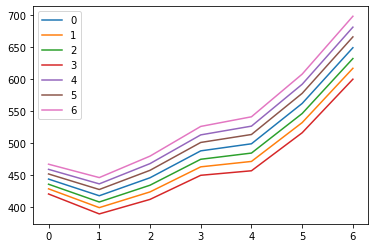

In [180]:
pd.DataFrame(arima.predict(12, X=newxreg, level=(80, 50, 95))).plot()